In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pyprojroot import here

def plot_metrics(results_df, mmd_metrics, xlabel="Number of Denoising Steps", axes=None, descriptive_ylabels=False):
    """
    Plot metrics with dynamic subplot layout.
    
    Args:
        results_df: DataFrame containing the results
        mmd_metrics: List of MMD metric names to plot
        experiment_name: Name of the experiment ("denoising-iterations" or "training-iterations")
    
    Returns:
        The matplotlib figure object
    """
    
    # Calculate number of plots needed (validity + polyscore + mmd metrics)
    n_plots = 2 + len(mmd_metrics)
    
    if axes is None:
        # Calculate grid dimensions (max 4 columns)
        n_cols = min(4, n_plots)
        n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5*n_cols, 2*n_rows))
        axes = axes.flatten()
    else:
        fig = None
        assert axes.shape == (n_plots,)

    sns.set_palette("colorblind")
    colors = sns.color_palette("colorblind")
    
    # Plot validity
    ax = axes[0]
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Validity")
    ax.plot(
        results_df["num_steps"],
        results_df["validity"],
        color="#7e9ef7",
    )
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    ax.set_ylim([0, 1])
    ax.set_title("Validity")
    
    # Plot polyscore
    ax = axes[1]
    ax.set_xlabel(xlabel)
    ax.set_ylabel("PolyGraphScore")
    ax.plot(
        results_df["num_steps"],
        results_df["polyscore"],
        color="black",
    )
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    ax.set_ylim([0, 1])
    ax.set_title("PolyGraphScore")
    
    # Plot MMD metrics
    descriptor_colors = {
        "orbit": colors[0],
        "degree": colors[1],
        "spectral": colors[2],
        "clustering": colors[3],
        "gin": colors[4],
    }


    
    for idx, metric in enumerate(mmd_metrics, start=2):
        ax = axes[idx]

        if descriptive_ylabels:
            mmd_ylabel = metric.replace("_mmd", "").title() + " RBF"
        else:
            mmd_ylabel = "MMD²"
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(mmd_ylabel)
        color = next((color for key, color in descriptor_colors.items() if key in metric), "black")
        ax.plot(
            results_df["num_steps"],
            results_df[metric],
            color=color,
        )
        ax.yaxis.set_major_locator(plt.MaxNLocator(6))
        ax.set_title(metric.replace("_mmd", "").title() + " RBF")
    
    # Hide unused subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    return fig


with open("/fs/pool/pool-mlsb/polygraph/rcparams.json", "r") as f:
    style = json.load(f)

plt.rcParams.update(style)

np.random.seed(42)
torch.manual_seed(42)

## Number of denoising iterations

,orbit_pgs,degree_pgs,spectral_pgs,clustering_pgs,gin_pgs,orbit_mmd,degree_mmd,spectral_mmd,clustering_mmd,gin_mmd,polyscore,validity,num_steps
0,0.999892,0.687399,0.992531,0.999419,0.786396,0.646000,0.075055,0.030497,0.475074,0.204133,0.999892,0.000000,15
1,0.968396,0.431437,0.801634,0.898917,0.567959,0.187895,0.027988,0.009035,0.120622,0.095624,0.968396,0.040527,30
2,0.898303,0.333442,0.662987,0.757381,0.450453,0.092112,0.020756,0.004923,0.058424,0.065980,0.898303,0.187012,45
3,0.824917,0.290912,0.523879,0.673549,0.388549,0.067964,0.015918,0.003385,0.037671,0.046805,0.824917,0.307617,60
4,0.733398,0.326843,0.457535,0.574815,0.389909,0.050569,0.018239,0.002830,0.034873,0.035026,0.733398,0.440918,75
5,0.671249,0.281001,0.414580,0.489487,0.349000,0.043152,0.015778,0.002461,0.025801,0.032083,0.671249,0.512695,90


/tmp/ipykernel_17543/1677063962.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


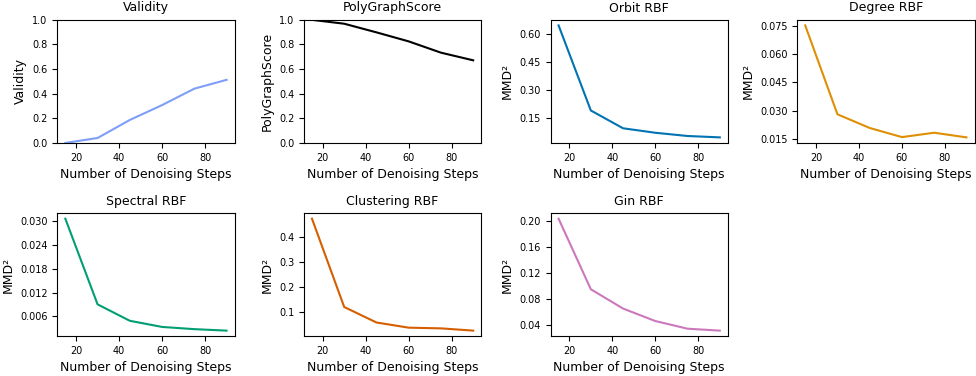

NameError: name 'xlabel' is not defined

In [2]:
experiment = "model-quality/denoising-iterations"

results = pd.read_csv(
    f"/fs/pool/pool-mlsb/polygraph/{experiment}/results.csv"
)
display(results)

# Define MMD metrics to plot
mmd_metrics = ["orbit_mmd", "degree_mmd", "spectral_mmd", "clustering_mmd", "gin_mmd"]

# Create and save the plot
fig = plot_metrics(results, mmd_metrics, "Number of Denoising Steps")
fig.savefig(
    here() / ".local/plots" / f"{experiment.replace('/', '_')}_validity_polyscore_all_mmd.pdf",
    bbox_inches='tight'
)
plt.tight_layout()
plt.show()
plt.close(fig)

# Define MMD metrics to plot
brief_mmd_metrics = ["orbit_mmd",]

# Create and save the plot
fig = plot_metrics(results, brief_mmd_metrics, xlabel)
fig.savefig(
    here() / ".local/plots" / f"{experiment.replace('/', '_')}_validity_polyscore_brief_mmd.pdf",
    bbox_inches='tight'
)
plt.tight_layout()
plt.show()
plt.close(fig)

In [21]:
pgs_columns = ["num_steps", "validity", "polyscore", "orbit_pgs", "degree_pgs", "spectral_pgs", "clustering_pgs", "gin_pgs"]
pgs_df = results[pgs_columns]
header = ["\# Steps", "Validity", "PolyGraphScore", "Orbit PGS", "Degree PGS", "Spectral PGS", "Clustering PGS", "GIN PGS"]
formatters = [lambda x: x, lambda x: "\\formatpercent{"+str(x)+"}"] + [lambda x: "\\num[round-mode=places, round-precision=2]{"+str(x)+"}"] * 6
print(pgs_df.to_latex(columns=pgs_columns, index=False, header=header, formatters=formatters, column_format="l|cc|ccccc"))

\begin{tabular}{l|cc|ccccc}
\toprule
\# Steps & Validity & PolyGraphScore & Orbit PGS & Degree PGS & Spectral PGS & Clustering PGS & GIN PGS \\
\midrule
15 & \formatpercent{0.0} & \num[round-mode=places, round-precision=2]{0.9998915898930651} & \num[round-mode=places, round-precision=2]{0.9998915898930651} & \num[round-mode=places, round-precision=2]{0.687398903089308} & \num[round-mode=places, round-precision=2]{0.9925307239652263} & \num[round-mode=places, round-precision=2]{0.9994188517386228} & \num[round-mode=places, round-precision=2]{0.7863959399266955} \\
30 & \formatpercent{0.04052734375} & \num[round-mode=places, round-precision=2]{0.9683962029782184} & \num[round-mode=places, round-precision=2]{0.9683962029782184} & \num[round-mode=places, round-precision=2]{0.4314373107140501} & \num[round-mode=places, round-precision=2]{0.8016335766308356} & \num[round-mode=places, round-precision=2]{0.8989172110907925} & \num[round-mode=places, round-precision=2]{0.5679589397942207} \\
45

In [22]:
pgs_columns = ["num_steps", "validity", "orbit_mmd", "degree_mmd", "spectral_mmd", "clustering_mmd", "gin_mmd"]
pgs_df = results[pgs_columns]
header = ["\# Steps", "Validity", "Orbit RBF", "Degree RBF", "Spectral RBF", "Clustering RBF", "GIN RBF"]
formatters = [lambda x: x, lambda x: "\\formatpercent{"+str(x)+"}"] + [lambda x: "\\num[round-mode=places, round-precision=4]{"+str(x)+"}"] * 6
print(pgs_df.to_latex(columns=pgs_columns, index=False, header=header, formatters=formatters, column_format="l|c|ccccc"))

\begin{tabular}{l|c|ccccc}
\toprule
\# Steps & Validity & Orbit RBF & Degree RBF & Spectral RBF & Clustering RBF & GIN RBF \\
\midrule
15 & \formatpercent{0.0} & \num[round-mode=places, round-precision=4]{0.6459998934396883} & \num[round-mode=places, round-precision=4]{0.0750545421304689} & \num[round-mode=places, round-precision=4]{0.0304972167049322} & \num[round-mode=places, round-precision=4]{0.4750743269760304} & \num[round-mode=places, round-precision=4]{0.2041332719982833} \\
30 & \formatpercent{0.04052734375} & \num[round-mode=places, round-precision=4]{0.1878949737877178} & \num[round-mode=places, round-precision=4]{0.02798774991599} & \num[round-mode=places, round-precision=4]{0.0090351474001322} & \num[round-mode=places, round-precision=4]{0.1206222115196018} & \num[round-mode=places, round-precision=4]{0.0956237389583333} \\
45 & \formatpercent{0.18701171875} & \num[round-mode=places, round-precision=4]{0.0921115235100258} & \num[round-mode=places, round-precision=4]{0.0207

## Number of Training Epochs

/tmp/ipykernel_17543/1677063962.py:99: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


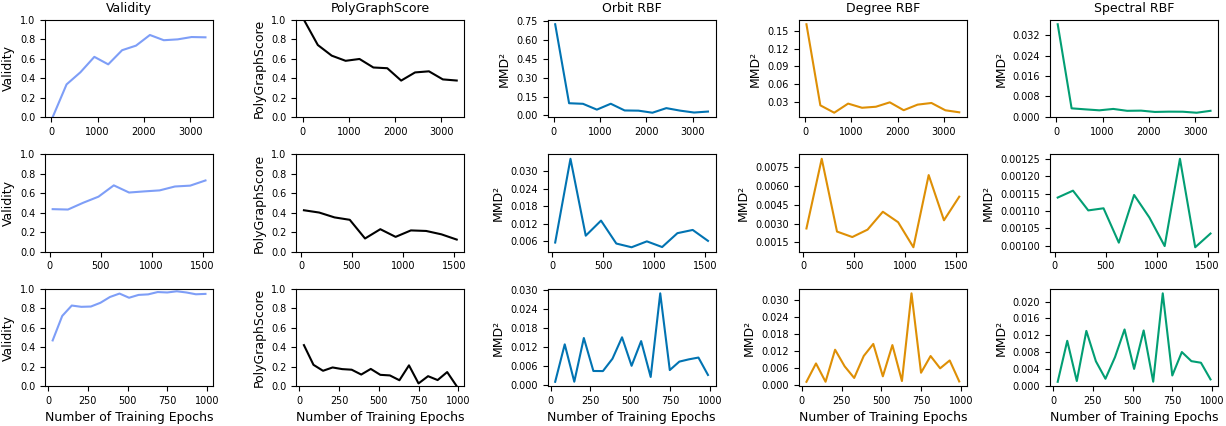

In [12]:
mmd_metrics = ["orbit_mmd", "degree_mmd", "spectral_mmd"]
datasets = ["planar-procedural", "sbm-procedural", "lobster-procedural"]
num_cols = 2 + len(mmd_metrics)
fig, axes = plt.subplots(3, num_cols, figsize=(2.5*num_cols, 1.5*3))

for i, dataset in enumerate(datasets):
    experiment = f"/fs/pool/pool-mlsb/polygraph/digress-samples/{dataset}"
    results = pd.read_csv(
        f"{experiment}/results.csv"
    )
    plot_metrics(results, mmd_metrics, "Number of Training Epochs", axes[i, :])
    
for i in range(1, 3):
    for j in range(num_cols):
        axes[i, j].set_title("")


for i in range(2):
    for j in range(num_cols):
        axes[i, j].set_xlabel("")

    ds_name = datasets[i].split("-")[0]
    if ds_name == "sbm":
        ds_name = ds_name.upper()
    else:
        ds_name = ds_name.title()
    
    #axes[i, 0].set_title(ds_name)
    #for j in range(1, 3):
    #    axes[i, j].set_title("")

plt.tight_layout()
plt.show()
fig.savefig(
    here() / ".local/plots" / f"all_training_epochs.pdf",
    bbox_inches='tight'
)
plt.close(fig)